# Imports

In [70]:
from os.path import exists

import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Load csv files

In [31]:
def load_data(fname):
    # Make sure it exists
    if not exists(fname):
        raise Exception('USER ERROR: Couldnt find the file <%s>..' % fname)

    # Read the csv as a df
    df = pd.read_csv(fname)
    return df

In [32]:
playbyplay_df = load_data("./data/playbyplay_data_dump.csv")
game_df = load_data("./data/match_data_dump.csv")
player_df = load_data("./data/player_data_dump.csv")

In [95]:
temp_playbyplay_df = pd.merge(playbyplay_df, player_df[['gameId', 'playerId', 'teamId']], on=['gameId', 'playerId'])
pbp_df = pd.merge(temp_playbyplay_df, game_df[['gameId', 'homeTeamId', 'awayTeamId']], on=['gameId'])
pbp_df[['homeTeamId', 'awayTeamId']] = pbp_df[['homeTeamId', 'awayTeamId']].astype(int)
pbp_df['team'] = np.where((pbp_df.teamId == pbp_df.homeTeamId), 'home', 'away')
pbp_df.drop(columns=['teamId', 'homeTeamId', 'awayTeamId', 'playerId', 'time', 'dateTime'], inplace=True)
# renaming type values
pbp_df.type.replace(
    {
        'FieldGoalMissed': 'fg_missed', 'Rebound': 'reb', 'FieldGoalMade': 'fg_made', 'Steal': 'stl',
        'FreeThrowMissed': 'ft_missed', 'FreeThrowMade': 'ft_made',
        'Turnover': 'to', 'Goaltending': 'to', 'LaneViolation': 'to', 'Traveling': 'to', 'Palming': 'to',
        'ShootingFoul': 'pf', 'PersonalFoul': 'pf', 'OffensiveFoul': 'pf', 'LooseBallFoul': 'pf',
        'TechnicalFoul': 'pf', 'Foul': 'pf', 'FlagrantFoul': 'pf'
    },
    inplace=True
)

# Create features dataframe

Filter dataframe by quarter

In [33]:
def get_quarter_df(df, quarter, start=True):
    if start:
        minutes = (df.remainingMinutes >= 6)
    else:
        minutes = (df.remainingMinutes < 6)
    return df[
        (df.quarter == quarter) &
        minutes
        ].sort_values(by=['playId'])

Retrieve lead changes for each game in dataframe

In [34]:
def get_lead_changes(df):
    df['lead'] = df.apply(
        lambda x: 1 if x['homeScore'] > x['awayScore'] else (-1 if x['homeScore'] < x['awayScore'] else 0), axis=1)

    lead_dict = {}
    for gameId in df.gameId.unique():
        game_df = df[df.gameId == gameId]
        lead_dict[gameId] = sum(np.sign(game_df['lead']).diff().ne(0))
    lead_df = pd.DataFrame.from_dict(lead_dict, orient='index')
    lead_df.reset_index(inplace=True)
    lead_df.rename(columns={'index': 'gameId', 0: 'lead_changes'}, inplace=True)
    return lead_df

Retrieve score related stats for each game in dataframe

In [35]:
def get_score_stats(df):
    score_dict = {'gameId': [], 'homeScore': [], 'awayScore': []}
    for gameId in df.gameId.unique():
        game_df = df[df.gameId == gameId]
        last_row_df = game_df.iloc[-1:]
        score_dict['gameId'].append(last_row_df['gameId'].values[0])
        score_dict['homeScore'].append(last_row_df['homeScore'].values[0])
        score_dict['awayScore'].append(last_row_df['awayScore'].values[0])
    score_df = pd.DataFrame.from_dict(score_dict)
    score_df['pointDiff'] = score_df['homeScore'] - score_df['awayScore']
    score_df['pointSum'] = score_df['homeScore'] + score_df['awayScore']
    return score_df

Create stats dataframe from event data

In [36]:
def get_stats(df, quarter=None):
    stats_counts = df.groupby(['gameId', 'team', 'type']).size()
    stats_counts = stats_counts.reset_index()
    stats_counts.rename(columns={0: 'count'}, inplace=True)
    if quarter is not None:
        stats_counts['stat'] = 'q' + str(quarter) + '_' + stats_counts['team'] + '_' + stats_counts['type']
    else:
        stats_counts['stat'] = stats_counts['team'] + '_' + stats_counts['type']
    stats_counts.drop(columns=['team', 'type'], inplace=True)
    stats_df = stats_counts.pivot_table(index=['gameId'], columns=['stat'], values='count').fillna(0)
    stats_df.reset_index(inplace=True)

    lead_df = get_lead_changes(df)
    if quarter is not None:
        lead_df.rename(columns={
            'lead_changes': 'q' + quarter + '_lead_changes'
        }, inplace=True)
    stats_df = pd.merge(stats_df, lead_df, on='gameId')

    score_df = get_score_stats(df)
    if quarter is not None:
        score_df.rename(columns={
            'homeScore': 'q' + quarter + '_h_score',
            'awayScore': 'q' + quarter + '_a_score',
            'pointDiff': 'q' + quarter + '_pointDiff',
            'pointSum': 'q' + quarter + '_pointSum'
        }, inplace=True)
    stats_df = pd.merge(stats_df, score_df, on='gameId')

    return stats_df

In [37]:
def build_stats_df():
    temp_playbyplay_df = pd.merge(playbyplay_df, player_df[['gameId', 'playerId', 'teamId']], on=['gameId', 'playerId'])
    pbp_df = pd.merge(temp_playbyplay_df, game_df[['gameId', 'homeTeamId', 'awayTeamId']], on=['gameId'])
    pbp_df[['homeTeamId', 'awayTeamId']] = pbp_df[['homeTeamId', 'awayTeamId']].astype(int)
    pbp_df['team'] = np.where((pbp_df.teamId == pbp_df.homeTeamId), 'home', 'away')
    pbp_df.drop(columns=['teamId', 'homeTeamId', 'awayTeamId', 'playerId', 'time', 'dateTime'], inplace=True)
    # renaming type values
    pbp_df.type.replace(
        {
            'FieldGoalMissed': 'fg_missed', 'Rebound': 'reb', 'FieldGoalMade': 'fg_made', 'Steal': 'stl',
            'FreeThrowMissed': 'ft_missed', 'FreeThrowMade': 'ft_made',
            'Turnover': 'to', 'Goaltending': 'to', 'LaneViolation': 'to', 'Traveling': 'to', 'Palming': 'to',
            'ShootingFoul': 'pf', 'PersonalFoul': 'pf', 'OffensiveFoul': 'pf', 'LooseBallFoul': 'pf',
            'TechnicalFoul': 'pf', 'Foul': 'pf', 'FlagrantFoul': 'pf'
        },
        inplace=True
    )
    # dropping KickedBall and JumpBall
    pbp_df.drop(pbp_df[pbp_df.type.isin(['KickedBall', 'JumpBall'])].index, inplace=True)

    # q1_start_stats = get_stats(get_quarter_df(pbp_df, '1'), '1_s')
    # q1_end_stats = get_stats(get_quarter_df(pbp_df, '1', start=False), '1_e')
    # q2_start_stats = get_stats(get_quarter_df(pbp_df, '2'), '2_s')
    # q2_end_stats = get_stats(get_quarter_df(pbp_df, '2', start=False), '2_e')
    # # q3_start_stats = get_stats(get_quarter_df(pbp_df, '3'), '3_s')
    # # q3_end_stats = get_stats(get_quarter_df(pbp_df, '3', start=False), '3_e')
    # q1_df = pd.merge(q1_start_stats, q1_end_stats, on=['gameId'])
    # q2_df = pd.merge(q2_start_stats, q2_end_stats, on=['gameId'])
    # # q3_df = pd.merge(q3_start_stats, q3_end_stats, on=['gameId'])
    # stats_df = pd.merge(q1_df, q2_df, on=['gameId'])
    # # stats_df = pd.merge(stats_df, q3_df, on=['gameId'])
    # stats_df = pd.merge(stats_df, game_df[['gameId', 'pointsDiff']], on=['gameId'])

    game_quarter_array = pbp_df.groupby('gameId')['quarter'].unique()

    games_drop = []
    for index, quarter_array in game_quarter_array.items():
        if '1' not in quarter_array or '2' not in quarter_array:
            games_drop.append(index)

    pbp_df.drop(pbp_df[pbp_df.gameId.isin(games_drop)].index, inplace=True)
    # check without different stats for each quarter
    half_df = pbp_df[(pbp_df.quarter.isin(['1', '2']))].sort_values(by=['playId'])
    stats_df = get_stats(half_df)
    stats_df = pd.merge(stats_df, game_df[['gameId', 'pointsDiff']], on=['gameId'])

    stats_df.loc[stats_df['pointsDiff'] > 0, 'Result'] = 1
    stats_df.loc[(stats_df['pointsDiff'] < 0), 'Result'] = 0
    stats_df.loc[:, ~stats_df.columns.isin(['gameId'])] = stats_df.loc[:, ~stats_df.columns.isin(['gameId'])].astype(
        int)
    stats_df.drop(columns='pointsDiff', inplace=True)
    return stats_df

In [49]:
stats_filename = './data/half_stats.csv'
if exists(stats_filename):
    stats_df = load_data(stats_filename)
else:
    stats_df = build_stats_df()
    stats_df.to_csv(stats_filename, index=False)

X = stats_df.loc[:, ~stats_df.columns.isin(['gameId', 'Result'])]
y = stats_df[['Result']]

# Dataset

# Classification

In [50]:
def experiments(X_train, y_train, X_test, y_test):
    dfs = []

    models = [
        ('LR', LogisticRegression()),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB())
    ]

    results = []

    names = []

    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

    target_names = ['win', 'loss']

    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))

        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)

    return final

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=.75)
final = experiments(X_train, y_train, X_test, y_test)
final

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arr

LR
              precision    recall  f1-score   support

         win       0.69      0.59      0.64       479
        loss       0.74      0.81      0.77       686

    accuracy                           0.72      1165
   macro avg       0.71      0.70      0.71      1165
weighted avg       0.72      0.72      0.72      1165



C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\thoma\AppData\Local\Programs\Pytho

RF
              precision    recall  f1-score   support

         win       0.65      0.58      0.61       479
        loss       0.73      0.78      0.75       686

    accuracy                           0.70      1165
   macro avg       0.69      0.68      0.68      1165
weighted avg       0.70      0.70      0.70      1165



C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: Data

KNN
              precision    recall  f1-score   support

         win       0.60      0.56      0.58       479
        loss       0.71      0.73      0.72       686

    accuracy                           0.66      1165
   macro avg       0.65      0.65      0.65      1165
weighted avg       0.66      0.66      0.66      1165



C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-

SVM
              precision    recall  f1-score   support

         win       0.71      0.56      0.62       479
        loss       0.73      0.84      0.78       686

    accuracy                           0.72      1165
   macro avg       0.72      0.70      0.70      1165
weighted avg       0.72      0.72      0.71      1165

GNB
              precision    recall  f1-score   support

         win       0.67      0.67      0.67       479
        loss       0.77      0.77      0.77       686

    accuracy                           0.73      1165
   macro avg       0.72      0.72      0.72      1165
weighted avg       0.73      0.73      0.73      1165



C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.093892,0.007564,0.716738,0.714326,0.716738,0.713576,0.784494,LR
1,0.073294,0.008576,0.722461,0.721548,0.722461,0.719815,0.778574,LR
2,0.074523,0.011224,0.723891,0.723042,0.723891,0.723394,0.791458,LR
3,0.070163,0.009014,0.716738,0.714330,0.716738,0.714182,0.779827,LR
4,0.057796,0.008016,0.712446,0.710123,0.712446,0.709658,0.792058,LR
5,0.398528,0.044894,0.705293,0.702883,0.705293,0.703094,0.767876,RF
6,0.474376,0.031086,0.698140,0.697859,0.698140,0.692824,0.755983,RF
7,0.720783,0.040510,0.699571,0.698272,0.699571,0.698777,0.768979,RF
8,0.382858,0.041000,0.688126,0.684792,0.688126,0.684592,0.751780,RF
9,0.374085,0.036222,0.726753,0.724802,0.726753,0.724496,0.782812,RF


# Fine tune parameters

In [52]:
def fine_tune_models(X_train, y_train, X_test, y_test):
    models = [
        ('LR', LogisticRegression()),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB())
    ]

    params = [
        {
            'penalty': ['none', 'l1', 'l2'], 'C': [0.1, 1, 10]
        },
        {
            'bootstrap': [True], 'max_depth': [50, 100], 'max_features': [2, 3], 'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 5, 10], 'n_estimators': [100, 500, 1000]
        },
        {
            'n_neighbors': [3, 5, 7], 'p': [1, 2]
        },
        {
            'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly', 'sigmoid']
        },
        {
            'var_smoothing': np.logspace(0, -9, num=100)
            # },
            # {
            #     'max_depth': range(2, 10, 1),
            #     'n_estimators': range(60, 220, 40),
            #     'learning_rate': [0.1, 0.01, 0.05]
        }
    ]

    best_models = {}

    for (name, model), param in zip(models, params):
        print(name)
        best_model = fine_tune(model, param, X_train, y_train, X_test, y_test)

        best_models[name] = best_model

    return best_models

In [53]:
def fine_tune(model, params, X_train, y_train, X_test, y_test):
    target_names = ['win', 'loss']

    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    model_grid = GridSearchCV(estimator=model,
                              param_grid=params,
                              cv=kfold,
                              verbose=1,
                              scoring='accuracy', n_jobs=-1)

    model_grid.fit(X_train, y_train)
    best_model = model_grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Accuracy: {}'.format(accuracy_score(y_pred, y_test.Result.values)))
    return best_model

In [54]:
best_models = fine_tune_models(X_train, y_train, X_test, y_test)
best_models

LR
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72074392        nan 0.7193133  0.72074392        nan 0.7193133
 0.72074392        nan 0.71988555]
  warnings.warn(
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

I

              precision    recall  f1-score   support

         win       0.69      0.59      0.64       479
        loss       0.74      0.81      0.78       686

    accuracy                           0.72      1165
   macro avg       0.72      0.70      0.71      1165
weighted avg       0.72      0.72      0.72      1165

Accuracy: 0.7227467811158799
RF
Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


              precision    recall  f1-score   support

         win       0.68      0.59      0.63       479
        loss       0.74      0.81      0.77       686

    accuracy                           0.72      1165
   macro avg       0.71      0.70      0.70      1165
weighted avg       0.72      0.72      0.71      1165

Accuracy: 0.7184549356223175
KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

         win       0.61      0.57      0.59       479
        loss       0.71      0.75      0.73       686

    accuracy                           0.68      1165
   macro avg       0.66      0.66      0.66      1165
weighted avg       0.67      0.68      0.67      1165

Accuracy: 0.6755364806866953
SVM
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

         win       0.72      0.54      0.62       479
        loss       0.73      0.85      0.78       686

    accuracy                           0.72      1165
   macro avg       0.72      0.70      0.70      1165
weighted avg       0.72      0.72      0.72      1165

Accuracy: 0.7236051502145923
GNB
Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

         win       0.67      0.64      0.65       479
        loss       0.76      0.77      0.77       686

    accuracy                           0.72      1165
   macro avg       0.71      0.71      0.71      1165
weighted avg       0.72      0.72      0.72      1165

Accuracy: 0.7201716738197425


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'LR': LogisticRegression(C=0.1, penalty='none'),
 'RF': RandomForestClassifier(max_depth=100, max_features=2, min_samples_split=5,
                        n_estimators=500),
 'KNN': KNeighborsClassifier(n_neighbors=7, p=1),
 'SVM': SVC(C=10),
 'GNB': GaussianNB(var_smoothing=0.03511191734215131)}

In [77]:
metrics_dict = {
    'LR': [],
    'RF': [],
    'KNN': [],
    'SVM': [],
    'GNB': []
}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    metrics_dict[name].append(accuracy_score(y_pred, y_test))
    metrics_dict[name].append(precision_score(y_pred, y_test))
    metrics_dict[name].append(recall_score(y_pred, y_test))
    metrics_dict[name].append(f1_score(y_pred, y_test))
metrics_df = pd.DataFrame.from_dict(metrics_dict, columns=['accuracy', 'precision', 'recall', 'f1'], orient='index')
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'classifier'}, inplace=True)
metrics_df

,classifier,accuracy,precision,recall,f1
0,LR,0.722747,0.811953,0.741678,0.775226
1,RF,0.718455,0.809038,0.738032,0.771905
2,KNN,0.675536,0.752187,0.712707,0.731915
3,SVM,0.723605,0.849854,0.726933,0.783602
4,GNB,0.720172,0.774052,0.756410,0.765130


In [55]:
features = X.columns.values
features

array(['away_fg_made', 'away_fg_missed', 'away_ft_made', 'away_ft_missed',
       'away_pf', 'away_reb', 'away_stl', 'away_to', 'home_fg_made',
       'home_fg_missed', 'home_ft_made', 'home_ft_missed', 'home_pf',
       'home_reb', 'home_stl', 'home_to', 'lead_changes', 'homeScore',
       'awayScore', 'pointDiff', 'pointSum'], dtype=object)

Feature: away_fg_made, Score: -0.14246048544198855
Feature: away_fg_missed, Score: 0.03898900209898327
Feature: away_ft_made, Score: -0.0426397242134387
Feature: away_ft_missed, Score: 0.01629238118297044
Feature: away_pf, Score: 0.0022129742472207325
Feature: away_reb, Score: -0.0259840682713935
Feature: away_stl, Score: 0.03286938830789969
Feature: away_to, Score: 0.022156120801090962
Feature: home_fg_made, Score: 0.14889852700690961
Feature: home_fg_missed, Score: -0.002855840687211791
Feature: home_ft_made, Score: 0.0726072122170503
Feature: home_ft_missed, Score: 0.014364526492602463
Feature: home_pf, Score: -0.03404112020347001
Feature: home_reb, Score: -0.004067330356130493
Feature: home_stl, Score: -0.031753225558975286
Feature: home_to, Score: -0.028109894419108016
Feature: lead_changes, Score: -0.00040792004998727103
Feature: homeScore, Score: 0.017435833130584753
Feature: awayScore, Score: -0.017974711281248373
Feature: pointDiff, Score: 0.03541054441183186
Feature: pointSum

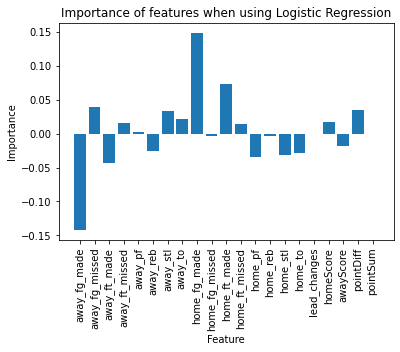

In [78]:
lr_best_model = best_models['LR']
importance = lr_best_model.coef_[0]
# summarize feature importance
for i, v in zip(features, importance):
    print('Feature: {}, Score: {}'.format(i, v))
# plot feature importance
from matplotlib import pyplot

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Importance of features when using Logistic Regression')
pyplot.ylabel('Importance')
pyplot.xlabel('Feature')
pyplot.xticks(range(len(features)), features, rotation = 90)
pyplot.savefig('lr_feature_importance.png', bbox_inches='tight')
pyplot.show()

Feature: away_fg_made, Score: 0.06307255022829045
Feature: away_fg_missed, Score: 0.046479025435220596
Feature: away_ft_made, Score: 0.03777835077988145
Feature: away_ft_missed, Score: 0.029159572300779733
Feature: away_pf, Score: 0.03580353927644539
Feature: away_reb, Score: 0.046919546384599616
Feature: away_stl, Score: 0.03202780091924486
Feature: away_to, Score: 0.02791438793147165
Feature: home_fg_made, Score: 0.06067955366241764
Feature: home_fg_missed, Score: 0.04792257192156654
Feature: home_ft_made, Score: 0.03932224730540412
Feature: home_ft_missed, Score: 0.028997986043415247
Feature: home_pf, Score: 0.03696843745372021
Feature: home_reb, Score: 0.045570853084479696
Feature: home_stl, Score: 0.03239794886667398
Feature: home_to, Score: 0.02915972321921806
Feature: lead_changes, Score: 0.04895854839512605
Feature: homeScore, Score: 0.06486046759267328
Feature: awayScore, Score: 0.0673937473375325
Feature: pointDiff, Score: 0.12808982774654823
Feature: pointSum, Score: 0.05052

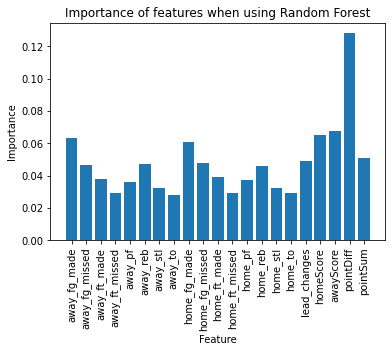

In [79]:
rf_best_model = best_models['RF']
importance = rf_best_model.feature_importances_
# summarize feature importance
for i, v in zip(features, importance):
    print('Feature: {}, Score: {}'.format(i, v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Importance of features when using Random Forest')
pyplot.ylabel('Importance')
pyplot.xlabel('Feature')
pyplot.xticks(range(len(features)), features, rotation = 90)
pyplot.savefig('rf_feature_importance.png', bbox_inches='tight')
pyplot.show()